In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:

pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df['Country Code']=pop_df['Country Code'].apply(lambda x: x.lower())
possible_countries=pop_df.query(" `2019` >=1000000")['Country Code'].values

excluded_iso3_codes = [
    "IRL",  # Ireland
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "COG",  # Republic of the Congo
    "COD",  # Democratic Republic of the Congo
    "GIN",  # Guinea
    "GNB",  # Guinea-Bissau
    "GNQ",  # Equatorial Guinea
    "PNG",  # Papua New Guinea
    "XKX",  # Kosovo (unofficial)
    "MNE",  # Montenegro
    "SRB",  # Serbia
    "TLS",   # Timor-Leste
    "GEO", #Georgia
    'SWZ', 
    'PRK', #North Korea
]
excluded_iso3_codes=[c.lower() for c in excluded_iso3_codes]


possible_iso=list(set(possible_countries)-set(excluded_iso3_codes))

In [3]:

df = pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'affiliation_country': 'Aff_country'}, inplace=True)
df=df[(df['Mention_country'].isin(possible_iso))&(df['Aff_country'].isin(possible_iso))]
df = df[df['year'].isin(np.arange(2002, 2020))]
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
physical_sciences=['MATH', 'ENGI', 'PHYS', 'COMP', 'MUL']
df=df[~df['subjarea'].isin(physical_sciences)]
df=df.groupby(['year', 'Mention_country'])['count'].sum().reset_index()


data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[data['year'].isin(np.arange(2002, 2020))]
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers']].dropna()
data.rename(columns={'iso3code':'Mention_country'}, inplace=True)
data['Mention_country']=data['Mention_country'].apply(lambda x: x.lower())
df=df.merge(data, on=['Mention_country', 'year'], how='outer')
df=df[df['Mention_country'].isin(possible_iso)]


countries_to_remove=[]
for c  in df['Mention_country'].unique():
    if ((~df['count'].isna()) & (df['Mention_country'] == c)).sum()<15:
        countries_to_remove.append(c)
        print(c)

print(len(countries_to_remove))


# Define the required year range
required_years = list(range(2002, 2020))

# Get the unique countries
unique_countries = df["Mention_country"].unique()

# Create a complete DataFrame with all country-year combinations
full_data = []
for country in unique_countries:
    country_data = df[df["Mention_country"] == country]
    existing_years = set(country_data["year"])
    
    for year in required_years:
        if year in existing_years:
            row = country_data[country_data["year"] == year].iloc[0].to_dict()
        else:
            row = {
                "year": year,
                "Mention_country": country,
                "count": 0,
                "gdp_per_capita": np.nan,
                "population": np.nan,
                "region": country_data["region"].iloc[0] if not country_data.empty else np.nan,
            }
        full_data.append(row)

# Convert to DataFrame
df_complete = pd.DataFrame(full_data)

df_complete['treated']=df_complete['Mention_country'].isin(abbr).astype(int)
df_complete['treated_CW']=df_complete['Mention_country'].isin(['yem', 'lby', 'syr']).astype(int)
df_complete['treated_GO']=df_complete['Mention_country'].isin(['egy', 'tun']).astype(int)
df_complete['treated_GC']=df_complete['Mention_country'].isin(['omn', 'kwt', 'bhr', 'mar','jor']).astype(int)
df_complete['post']=df_complete['year'].apply(lambda x: 0 if x>=2002 and x<=2010 else 1 )
df_complete['count']=df_complete['count'].fillna(0)
df_complete['log_count']=np.log(df_complete['count']+1)

df_complete[['region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[[ 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].ffill()
df_complete[[ 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[[ 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].bfill()
df_complete['log_gdp']=np.log(df_complete['gdp_per_capita'])
df_complete['log_population']=np.log(df_complete['population'])
df_complete['log_Rpop']=np.log(df_complete['padded_population_of_researchers']+1)
df_complete=df_complete[df_complete['Mention_country'].isin(possible_iso)].reset_index(drop=True)


0


In [4]:
dataset=df_complete
variables = [ 'log_gdp', 'log_population','log_Rpop']
country_list=['lby', 'syr']
Means={}
for country in dataset['Mention_country'].unique():
    country_data = dataset[(dataset['Mention_country'] == country) &(dataset['year']<=2010)]
    if country_data.empty:
        continue
    country_means = country_data[variables].mean().to_dict()
    Means[country]=country_means


country_means=pd.DataFrame(Means).T.reset_index().rename(columns={'index':'Mention_country'})

In [5]:
arab_spring_countries=['lby', 'syr', 'tun', 'egy', 'yem', 'bhr', 'mar', 'kwt', 'omn', 'jor']
arab_country_means=country_means[country_means['Mention_country'].apply(lambda mentions: mentions in arab_spring_countries)]
rest_country_means=country_means[~country_means['Mention_country'].apply(lambda mentions: mentions in arab_spring_countries)]

Text(0.5, 0, 'Log Researchers Population')

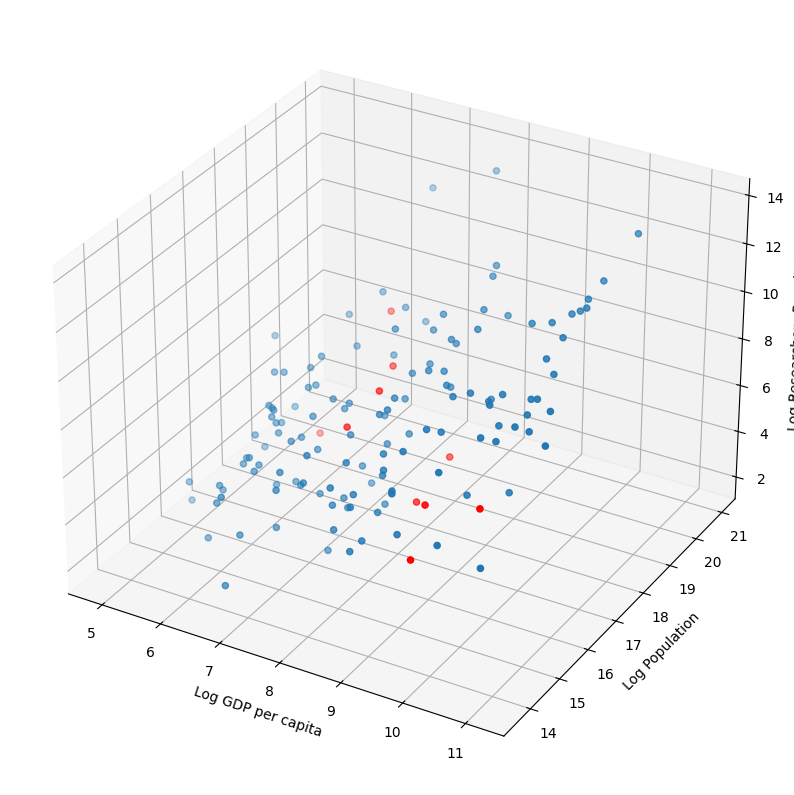

In [6]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 19))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(arab_country_means['log_gdp'], arab_country_means['log_population'], arab_country_means['log_Rpop'], color='r')
ax.scatter(rest_country_means['log_gdp'], rest_country_means['log_population'], rest_country_means['log_Rpop'])

ax.set_xlabel('Log GDP per capita')
ax.set_ylabel('Log Population')
ax.set_zlabel('Log Researchers Population')

In [36]:
def find_match( country_list, n_match_per_country, variables, dataset): 
    matched_countries = []
    for country in country_list:
        country_data = dataset[(dataset['Mention_country'] == country) &(dataset['year']<=2010)]
        if country_data.empty:
            continue
        country_means = country_data[variables].mean()
        
        # Exclude already treated countries and those already matched
        potential_matches = dataset[
            (~dataset['Mention_country'].isin(country_list)) & 
            (~dataset['Mention_country'].isin(matched_countries))
        ]
        
        potential_matches_means = potential_matches.groupby('Mention_country')[variables].mean()
        possible_possible=list(set(possible_iso)-set(abbr))
        potential_matches_means=potential_matches_means[potential_matches_means.index.isin(possible_possible)]
        # Calculate Euclidean distances
        distances = np.linalg.norm(potential_matches_means - country_means, axis=1)
        
        # Get the top N matches
        top_matches = potential_matches_means.index[np.argsort(distances)[:n_match_per_country]]
        
        matched_countries.extend(top_matches)
    
    return sorted(set(matched_countries))


In [45]:
n_counts=5
cw_match=find_match(['lby', 'syr', 'yem'], n_counts, variables, dataset)
GO_match=find_match( ['tun', 'egy'], n_counts, variables, dataset)
GC_match=find_match( ['omn', 'kwt', 'bhr', 'mar','jor'], n_counts, variables, dataset)

# Civil War

Matched=['alb',
 'aze',
 'bol',
 'cri',
 'dom',
 'ecu',
 'gtm',
 'khm',
 'mmr',
 'moz',
 'nam',
 'ner',
 'pan',
 'pry',
 'rwa']

* parallel trend-satisfied!
* Effect




In [46]:
df_new=df_complete[df_complete['Mention_country'].isin(['lby', 'syr', 'yem']+cw_match)]
model = smf.ols("log_count ~ treated* post +log_gdp+log_Rpop+ log_population+C(Mention_country) + C(year)", data=df_new).fit(cov_type='cluster', cov_kwds={'groups': df_new['Mention_country']})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     37.62
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           3.41e-10
Time:                        22:54:37   Log-Likelihood:                 100.48
No. Observations:                 324   AIC:                            -123.0
Df Residuals:                     285   BIC:                             24.49
Df Model:                          38                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 40, but rank is 17
  warnings.warn('covariance of constraints does not have full '


In [41]:
df_p=df_new[df_new['year']<2011].reset_index(drop=True)
df_p['time']=df_p['year']-2011
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ time+treated * time +log_gdp+log_Rpop+log_population+ C(Mention_country)", data=df_p).fit(cov_type='cluster', cov_kwds={'groups': df_p['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     109.8
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           3.57e-19
Time:                        22:53:48   Log-Likelihood:                 131.42
No. Observations:                 297   AIC:                            -186.8
Df Residuals:                     259   BIC:                            -46.48
Df Model:                          37                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 38, but rank is 5
  warnings.warn('covariance of constraints does not have full '



# GO 

matches=['bgr', 'blr', 'cub', 'dza', 'nga', 'pak', 'rou', 'tha', 'ukr', 'vnm']

* Parallel trend satisfied, but effect not signficant. 

In [42]:
df_new=df_complete[df_complete['Mention_country'].isin(['egy', 'tun']+GO_match)]
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated* post +log_gdp+log_Rpop+ log_population+C(Mention_country) + C(year)", data=df_new).fit(cov_type='cluster', cov_kwds={'groups': df_new['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     491.5
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           9.51e-24
Time:                        22:53:54   Log-Likelihood:                 241.11
No. Observations:                 396   AIC:                            -396.2
Df Residuals:                     353   BIC:                            -225.0
Df Model:                          42                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 44, but rank is 21
  warnings.warn('covariance of constraints does not have full '


In [43]:
df_p=df_new[df_new['year']<2011].reset_index(drop=True)
df_p['time']=df_p['year']-2011
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ time+treated * time +log_gdp+log_Rpop+log_population+ C(Mention_country)", data=df_p).fit(cov_type='cluster', cov_kwds={'groups': df_p['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     38.95
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           6.26e-10
Time:                        22:54:03   Log-Likelihood:                 158.85
No. Observations:                 198   AIC:                            -263.7
Df Residuals:                     171   BIC:                            -174.9
Df Model:                          26                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 27, but rank is 5
  warnings.warn('covariance of constraints does not have full '


# GC

matches=['are',
 'arm',
 'aze',
 'bih',
 'blr',
 'bwa',
 'col',
 'cri',
 'cyp',
 'dza',
 'est',
 'gab',
 'irq',
 'ken',
 'lbn',
 'lva',
 'mus',
 'nam',
 'pan',
 'per',
 'pri',
 'qat',
 'svn',
 'tto',
 'ury']


* Satisfied, but not significant
 

In [44]:
df_new=df_complete[df_complete['Mention_country'].isin(['omn', 'kwt', 'bhr', 'mar','jor']+GC_match)]
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated* post +log_gdp+log_Rpop+ log_population+C(Mention_country) + C(year)", data=df_new).fit(cov_type='cluster', cov_kwds={'groups': df_new['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     21.94
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           2.42e-19
Time:                        22:54:06   Log-Likelihood:                 358.10
No. Observations:                 990   AIC:                            -564.2
Df Residuals:                     914   BIC:                            -192.0
Df Model:                          75                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 77, but rank is 21
  warnings.warn('covariance of constraints does not have full '


In [34]:
df_p=df_new[df_new['year']<2011].reset_index(drop=True)
df_p['time']=df_p['year']-2011
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ time+treated * time +log_gdp+log_Rpop+log_population+ C(Mention_country)", data=df_p).fit(cov_type='cluster', cov_kwds={'groups': df_p['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     72.05
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.87e-15
Time:                        22:52:26   Log-Likelihood:                 165.04
No. Observations:                 270   AIC:                            -260.1
Df Residuals:                     235   BIC:                            -134.1
Df Model:                          34                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 35, but rank is 5
  warnings.warn('covariance of constraints does not have full '
